<a href="https://colab.research.google.com/github/gmazzitelli/studenti/blob/master/R_th.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
plt.style.use('fast')
plt.rc('font', size = 14, family ='Sans-Serif')

# download updated data
# repository italy https://github.com/pcm-dpc/COVID-19/tree/master/dati-andamento-nazionale
url_csv_file = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(url_csv_file)
# DATI COVID REGIONI
# istat http://dati.istat.it/Index.aspx?QueryId=26428#
url_csv_file = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv"
dr = pd.read_csv(url_csv_file)
print('aggiornamento al '+str(np.array(df['data'])[-1])[0:10])

aggiornamento al 2020-10-29


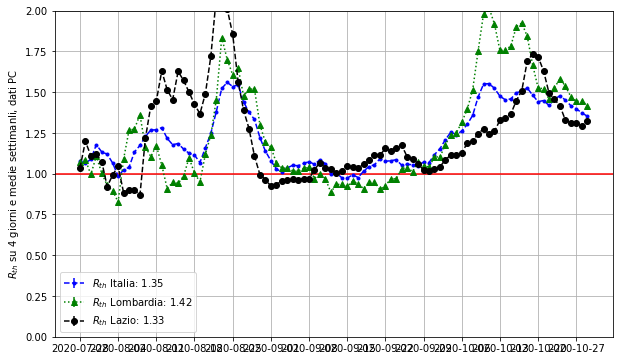

In [2]:
fig, ax = plt.subplots(figsize=(10,6))
Lombardia = dr.loc[(dr['denominazione_regione'] == 'Lombardia')].sort_values(by="data").copy()
Lazio = dr.loc[(dr['denominazione_regione'] == 'Lazio')].sort_values(by="data").copy()

def Rth(data, N=7, d=4):
  # https://www.facebook.com/DatiAnalisiCoronavirus/posts/142436764043174?__tn__=K-R
  N=7
  y = np.convolve(data, np.ones((N,))/N, mode='valid')
  x = np.linspace(0, len(y), len(y))
  d=4 
  return x[d:] , y[d:]/y[:-d]


#fig.autofmt_xdate()
#x.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

data = df['nuovi_positivi']
xd , y = Rth(data)

cut = len(df)-100
x = np.array(df.iloc[cut+6:,0])
for i in range(len(x)):
  x[i]=x[i][0:10]
ax.errorbar(x , y[xd>cut], yerr=0, fmt='b.--', label='$R_{th}$'+' Italia: {0:.2f}'.format(y[-1]))
data = Lombardia['nuovi_positivi']
xd , y = Rth(data)
ax.errorbar(x, y[xd>cut], yerr=0, fmt='g^:', label='$R_{th}$'+' Lombardia: {0:.2f}'.format(y[-1]))
data = Lazio['nuovi_positivi']
xd , y = Rth(data)
ax.errorbar(x , y[xd>cut], yerr=0, fmt='ko--', label='$R_{th}$'+' Lazio: {0:.2f}'.format(y[-1]))

ax.axhline(1, color='red')
#ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel(r'$R_{th}$ su 4 giorni e medie settimanli, dati PC')
ax.xaxis.set_major_locator(MultipleLocator(7))

ax.set_ylim(0,2)

ax.legend()
ax.grid()
plt.show()

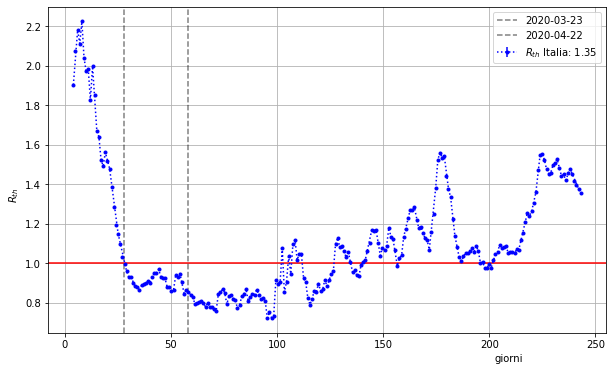

In [3]:
fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(0, len(df['data']), len(df['data']))
data = df['nuovi_positivi']
N=7
y = np.convolve(data, np.ones((N,))/N, mode='valid')
x = np.linspace(0, len(y), len(y))
d=4
y_past = y[:-d]
x_ = x[d:]
Rth = y[d:]/y_past
# ax.errorbar(x, y, yerr=0, fmt='k.:', label='running avarege')
ax.errorbar(x_, Rth, yerr=0, fmt='b.:', label='$R_{th}$'+' Italia: {0:.2f}'.format(Rth[-1]))
ax.axhline(1, color='red')
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel(r'$R_{th}$', horizontalalignment = 'left', y=0.4)
day=28
ax.axvline(day, color='black', linestyle='--', label='{:s}'.format(df.iloc[day, 0][0:10]), alpha=0.5)
day=58
ax.axvline(day, color='black', linestyle='--', label='{:s}'.format(df.iloc[day, 0][0:10]), alpha=0.5)

ax.legend()
ax.grid()
plt.show()

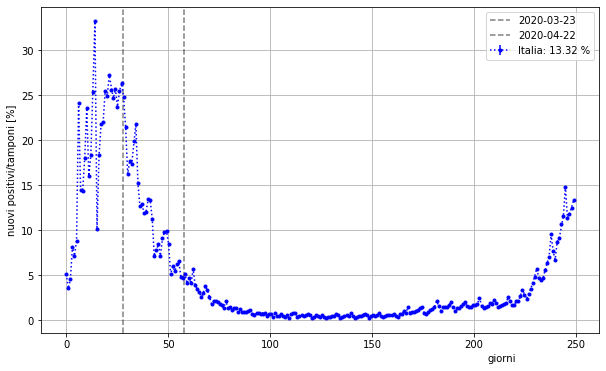

In [4]:
fig, ax = plt.subplots(figsize=(10,6))
x = np.linspace(0, len(df['data']), len(df['data']))
a = df['nuovi_positivi']
b = np.gradient(df['tamponi'])
y = a/b
err = y*np.sqrt((np.sqrt(a)/a)**2 + (np.sqrt(b)/b)**2)
ax.errorbar(x,y*100, yerr=0, fmt='b:.', label = "Italia: {0:.2f} %".format(y.values[-1]*100))
#GFPlot(y, ax, 4, 'b', label='casi', stat=True)
ax.set_xlabel('giorni', horizontalalignment = 'left', x=0.8)
ax.set_ylabel(r'nuovi positivi/tamponi [%]')
day=28
ax.axvline(day, color='black', linestyle='--', label='{:s}'.format(df.iloc[day, 0][0:10]), alpha=0.5)
day=58
ax.axvline(day, color='black', linestyle='--', label='{:s}'.format(df.iloc[day, 0][0:10]), alpha=0.5)
#ax.set_ylim(0,1)
ax.grid()
plt.legend()
plt.show()

In [5]:
def Exp(x, p0, p1): # negative exponential
    import numpy as np
    return p0*np.exp(x/p1)

def Infected(t, I0, mu, R0): # negative exponential
    import numpy as np
# https://medium.com/data-for-science/epidemic-modeling-101-or-why-your-covid19-exponential-fits-are-wrong-97aa50c55f8
    return I0*np.exp(mu*(R0-1)*t)

# def Logistic(x, L, k, x0):
#     import numpy as np
#     return L / (1. + np.exp(-k * (x - x0)))

def Logistic(x, a, b, c):
    import numpy as np
# https://it.wikipedia.org/wiki/Equazione_logistica
    return a / (1. + b * np.exp(-c * x))

def Logistic4(x, a, b, c, d):
    import numpy as np
# https://it.wikipedia.org/wiki/Equazione_logistica
    return a / (1. + b * np.exp(-c * x)) + d

def dLogistic(x, a, b, c):
    import numpy as np
    return a*b*c*np.exp(c*x)/(b+np.exp(c*x))**2

def Gompertz(x, a, b, c):
    import numpy as np
# https://en.wikipedia.org/wiki/Gompertz_function
    return a * np.exp(-b * np.exp(-c * x))

def dGompertz(x, a, b, c):
  import numpy as np
# https://en.wikipedia.org/wiki/Gompertz_function
  return a*b*c * np.exp(-b * np.exp(-c * x))*np.exp(-c * x)

def Gauss3(x, a0, x0, s0):
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))

def Line(x, m, q):
    import numpy as np
    return m*x + q

def ManSdtSubArr(arr, rescaled_avarege):
  import numpy as np
  if len(arr)>rescaled_avarege & rescaled_avarege>1:
    a_split     = np.array_split(arr, int(len(arr)/rescaled_avarege))
    a_split_avg = [np.mean(x) for x in a_split]
    a_split_err = [np.std(x) for x in a_split]
    return np.array(a_split_avg), np.array(a_split_err)
  else:
    return np.array(arr), np.sqrt(arr)


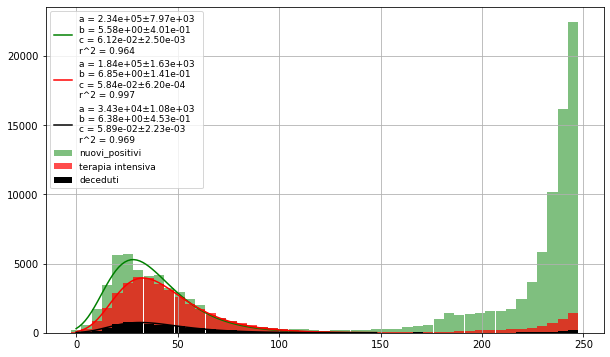

In [40]:
def fittalo(func, x, y, ax, p0, fmt='k'):
  from scipy.optimize import curve_fit
  from sklearn.metrics import r2_score
  popt, pcov = curve_fit(func,x, y, p0=p0)
  perr = np.sqrt(np.diag(pcov))
  r2=r2_score(y, func(x, *popt))
  xf = np.linspace(x.min(), x.max(), 100)
  ax.plot(xf, func(xf, *popt), fmt, label='a = {0:.2e}±{1:.2e}\nb = {2:.2e}±{3:.2e} \
  \nc = {4:.2e}±{5:.2e}\nr^2 = {6:.3f}'.format(popt[0], perr[0], popt[1], perr[1], popt[2], perr[2], r2))
  return ax
fig, ax = plt.subplots(figsize=(10,6))
average_day = 5
x = np.linspace(0, len(df['data']), len(df['data']))
y = df['totale_positivi']
y, err = ManSdtSubArr(y, average_day)

x = np.linspace(0, len(y)*average_day, len(y))
# ax.bar(x,y, color='blue', alpha=0.5, label='totale_positivi', width=average_day)
# fittalo(dGompertz, x[x<150], y[x<150], ax, [2e5,8., 0.1], 'b')

y = df['nuovi_positivi']
y, err = ManSdtSubArr(y, average_day)
ax.bar(x,y, color='green', alpha=0.5, label='nuovi_positivi', width=average_day) 
fittalo(dGompertz, x[x<150], y[x<150], ax, [4e6,7., 0.1], 'g')
y = df['terapia_intensiva']
y, err =  ManSdtSubArr(y, average_day)
ax.bar(x,y, color='red', alpha=0.7, label='terapia intensiva', width=average_day)
fittalo(dGompertz, x[x<150], y[x<150], ax, [1e5,9., 0.1], 'r')

y = np.gradient(df['deceduti'])
y, err =  ManSdtSubArr(y, average_day)
ax.bar(x,y, color='black', alpha=1, label='deceduti', width=average_day)
fittalo(dGompertz, x[x<150], y[x<150], ax, [3e4,8., 0.1], 'k')

#fittalo(Gauss3, x[x>200], y[x>200], ax, [10000,1000., 100.], 'k')
ax.legend(loc=2, prop={'size': 9})
ax.grid()
plt.show()

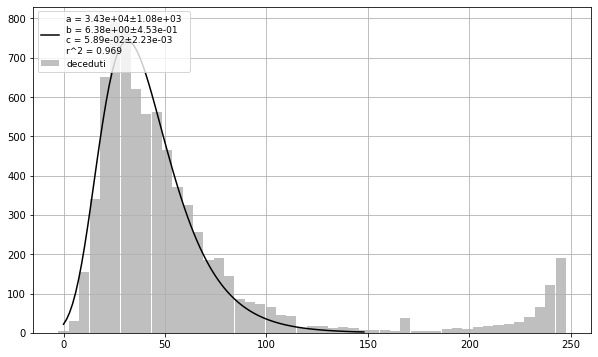

In [41]:
fig, ax = plt.subplots(figsize=(10,6))
y = np.gradient(df['deceduti'])
y, err =  ManSdtSubArr(y, average_day)
ax.bar(x,y, color='gray', alpha=0.5, label='deceduti', width=average_day)
fittalo(dGompertz, x[x<150], y[x<150], ax, [3e4,8., 0.1], 'k')

#fittalo(dGompertz, x[x>200], y[x>200], ax, [10e4,6., 0.06], 'k')
ax.legend(loc=2, prop={'size': 9})
ax.grid()
plt.show()